# Calculate volume fluxes across main CAA pathways for Stephan Krisch

Monthly September 2005-August 2006

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors
import cmocean
import netCDF4 as nc
import pandas as pd
from datetime import datetime
from mpl_toolkits.basemap import Basemap, cm
import xarray as xr

%matplotlib inline

#### Parameters:

In [7]:
# coordinates of boundaries
LS = (1584, 1584, 496, 534)
NS = (1580, 1630, 630, 630)
JS = (1609, 1609, 554, 583)

LS_len = LS[3]-LS[2]
NS_len = NS[1]-NS[0]
JS_len = JS[3]-JS[2]

land_color         = '#a9a7a2'
land_outline_color = '#373736'

#### Load files:

In [8]:
ANHA12 = nc.Dataset('/data/brogalla/ANHA12/ANHA12-EXH006_5d_gridT_y2002m01d05.nc', 'r')
ANHA12_lons  = np.array(ANHA12.variables['nav_lon'])
ANHA12_lats  = np.array(ANHA12.variables['nav_lat'])
ANHA12_depth = np.array(ANHA12.variables['deptht'])

In [9]:
mesh       = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
mesh_bathy = np.array(mesh.variables['hdept'][0])
tmask      = np.array(mesh.variables['tmask'])
land_mask  = np.ma.masked_where((tmask[0,:,:,:] > 0.1) , tmask[0,:,:,:]) 

In [10]:
print('Depth levels in ANHA12 configuration: ', [float(f'{d:.1f}') for d in ANHA12_depth])

Depth levels in ANHA12 configuration:  [0.5, 1.5, 2.6, 3.8, 5.1, 6.4, 7.9, 9.6, 11.4, 13.5, 15.8, 18.5, 21.6, 25.2, 29.4, 34.4, 40.3, 47.4, 55.8, 65.8, 77.9, 92.3, 109.7, 130.7, 155.9, 186.1, 222.5, 266.0, 318.1, 380.2, 453.9, 541.1, 643.6, 763.3, 902.3, 1062.4, 1245.3, 1452.3, 1684.3, 1941.9, 2225.1, 2533.3, 2865.7, 3220.8, 3597.0, 3992.5, 4405.2, 4833.3, 5274.8, 5727.9]


#### Map of boundaries

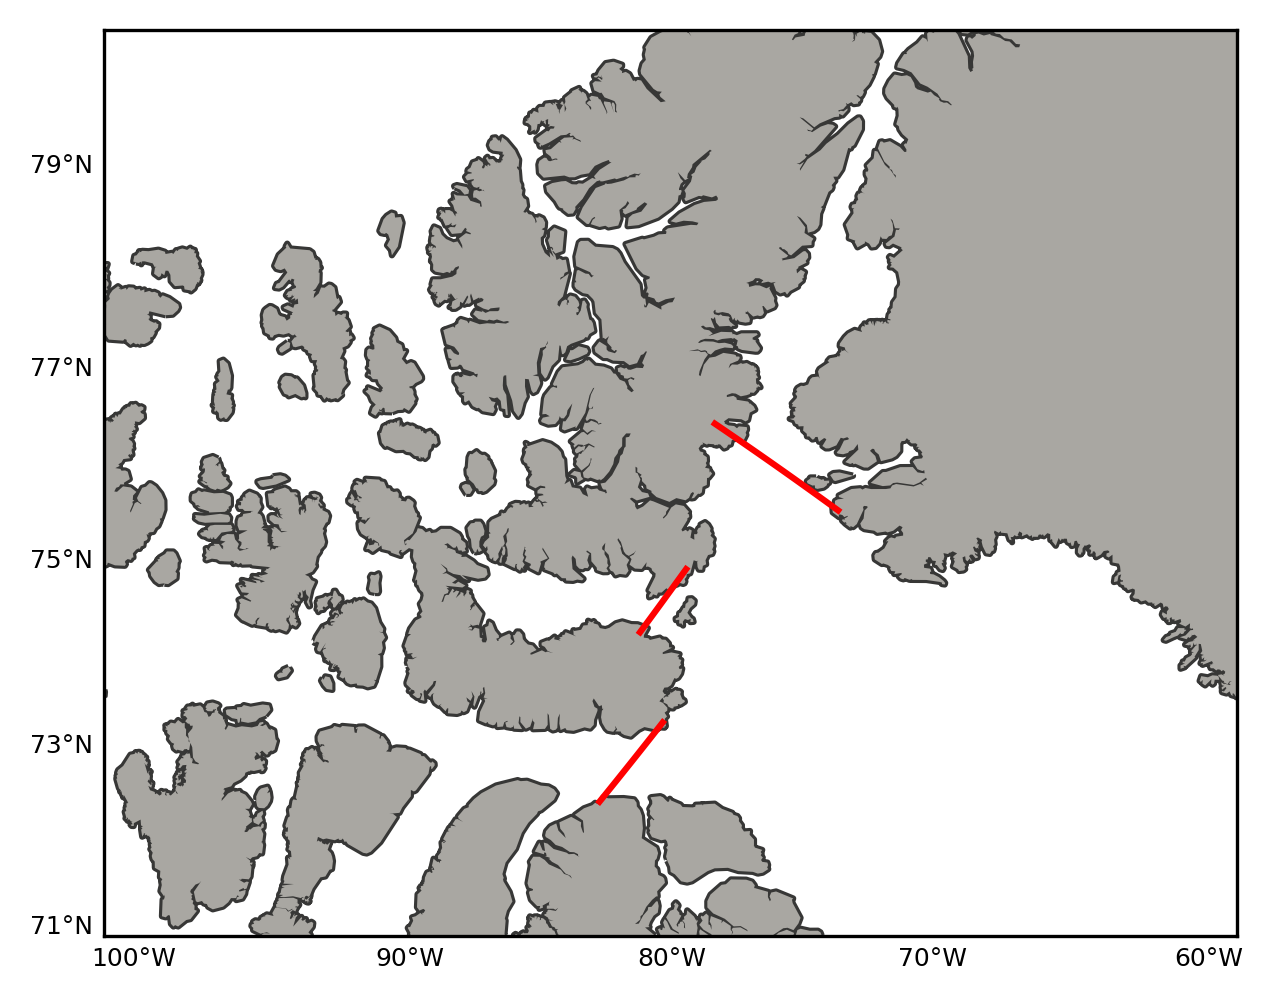

In [24]:
fig, ax1 = plt.subplots(figsize=(5, 4), dpi=300)

proj1 = Basemap(projection='stere',lat_0 = 77.5, lon_0 = -80, resolution='i', width=1.5e6, height=1.2e6, ax=ax1)
proj1.drawparallels(np.arange(int(59),int(90),2),labels=[1,0,0,0], linewidth=0.0, fontsize=6)
proj1.drawmeridians(np.arange(int(-140),int(-30),10),labels=[0,0,0,1], linewidth=0.0, fontsize=6)
proj1.drawcoastlines(color=land_outline_color, linewidth=1.5)
proj1.fillcontinents(color=land_color, lake_color=land_color, zorder=2);

x, y = proj1(ANHA12_lons, ANHA12_lats)
proj1.plot(x[LS[0],LS[2]:LS[3]], y[LS[0],LS[2]:LS[3]], '-r', linewidth=1.5) # Lancaster Sound
proj1.plot(x[NS[0]:NS[1],NS[2]], y[NS[0]:NS[1],NS[2]], '-r', linewidth=1.5) # Nares Strait
proj1.plot(x[JS[0],JS[2]:JS[3]], y[JS[0],JS[2]:JS[3]], '-r', linewidth=1.5) # Jones Sound

fig.savefig('/ocean/brogalla/GEOTRACES/figures/SK_boundaries.jpg', dpi=300, bbox_inches='tight')

#### Calculate transport

In [33]:
# Transports are in cubic metres per second
# 1 Sv = 1 million m3/s

## Double-check e3u and e3v to use for volume transport calculations

In [54]:
def load_transport(year, total_export):
    ts = xr.open_dataset(f'/ocean/brogalla/GEOTRACES/time-series/Stephan-2022-transport/time-series-{year}.nc')
    ts_LS = ts['transport_LS'].values
    ts_NS = ts['transport_NS'].values
    ts_JS = ts['transport_JS'].values
    
    # Split into upper and lower water column
    split = 18 # depth level at which the split happens (48 m)
    
    # For each cross section, calculate the total export, so ignoring return flows, I want only the negative volume fluxes.
    # Then, sum the fluxes over the depth levels (axis=1) and cross-section gridpoints (axis=2).
    if total_export:
        upper_JS = np.ma.masked_where((ts_JS[:,0:split,:] > 0), ts_JS[:,0:split,:]).sum(axis=(1,2))
        lower_JS = np.ma.masked_where((ts_JS[:,split:,:] > 0), ts_JS[:,split:,:]).sum(axis=(1,2))
        upper_NS = np.ma.masked_where((ts_NS[:,0:split,:] > 0), ts_NS[:,0:split,:]).sum(axis=(1,2))
        lower_NS = np.ma.masked_where((ts_NS[:,split:,:] > 0), ts_NS[:,split:,:]).sum(axis=(1,2))
        upper_LS = np.ma.masked_where((ts_LS[:,0:split,:] > 0), ts_LS[:,0:split,:]).sum(axis=(1,2))
        lower_LS = np.ma.masked_where((ts_LS[:,split:,:] > 0), ts_LS[:,split:,:]).sum(axis=(1,2))
    # For the net export, I take the sum of all negative and positive volume fluxes
    else:
        upper_JS = ts_JS[:,0:split,:].sum(axis=(1,2))
        lower_JS = ts_JS[:,split:,:].sum(axis=(1,2))
        upper_NS = ts_NS[:,0:split,:].sum(axis=(1,2))
        lower_NS = ts_NS[:,split:,:].sum(axis=(1,2))
        upper_LS = ts_LS[:,0:split,:].sum(axis=(1,2))
        lower_LS = ts_LS[:,split:,:].sum(axis=(1,2))
        
    return upper_JS, lower_JS, upper_NS, lower_NS, upper_LS, lower_LS

In [49]:
def create_time_series(year_start, year_end, total_export):
   
    uJS = np.empty([]); lJS = np.empty([])
    uNS = np.empty([]); lNS = np.empty([]); uLS = np.empty([]); lLS = np.empty([])
    
    # series of dates at which the model produces files.
    time_series=pd.date_range(start=str(year_start)+'-01-05', periods=72*(year_end+1-year_start), freq='5D')
    
    # load transports and calculate the sum of the transport across the boundary:
    for year in range(year_start, year_end+1):
        upperJS, lowerJS, upperNS, lowerNS, upperLS, lowerLS = load_transport(year, total_export)
        uJS = np.append(uJS, upperJS); lJS = np.append(lJS, lowerJS)
        uNS = np.append(uNS, upperNS); lNS = np.append(lNS, lowerNS)
        uLS = np.append(uLS, upperLS); lLS = np.append(lLS, lowerLS)
        
    return time_series, uJS[1:], lJS[1:], uNS[1:], lNS[1:], uLS[1:], lLS[1:]

In [50]:
def calc_transport(year_start, year_end, total_export=False):
    time_series, uJS, lJS, uNS, lNS, uLS, lLS = create_time_series(year_start, year_end, total_export)

    # Calculate the mean flux over the fill time period given by year_start to year_end
    upper_JS = uJS.sum()/len(uJS); lower_JS = lJS.sum()/len(uJS);
    upper_NS = uNS.sum()/len(uNS); lower_NS = lNS.sum()/len(uNS);
    upper_LS = uLS.sum()/len(uLS); lower_LS = lLS.sum()/len(uLS);
    
    # Print out the mean volume flux across the boundaries: (sverdrup is 1 million m3/s)
    if total_export:
        print('Total export across boundaries: units of Sverdrup')
    else:
        print('Net transport across boundaries: units of Sverdrup')
        
    print('--- Jones Sound:     upper ocean = {:.3f}, lower ocean = {:.3f}, sum = {:.3f}'.format(upper_JS*1e-6, lower_JS*1e-6, (upper_JS+lower_JS)*1e-6))
    print('--- Nares Strait:    upper ocean = {:.3f}, lower ocean = {:.3f}, sum = {:.3f}'.format(upper_NS*1e-6, lower_NS*1e-6, (upper_NS+lower_NS)*1e-6))
    print('--- Lancaster Sound: upper ocean = {:.3f}, lower ocean = {:.3f}, sum = {:.3f}'.format(upper_LS*1e-6, lower_LS*1e-6, (upper_LS+lower_LS)*1e-6))
    return

In [51]:
def plot_transport(time_series, uJS, lJS, uNS, lNS, uLS, lLS):
    # Create 4 subplots showing the time series of volume flux across each of the boundaries
    
    fig, ax = plt.subplots(3,1, figsize=(9,7), dpi=300)

    ax[0].plot([time_series[0], time_series[-1]], [0,0], '-k')
    ax[0].plot(time_series, uLS*1e-6, label='upper')
    ax[0].plot(time_series, lLS*1e-6, label='lower')
    ax[0].set_title('Lancaster Sound', fontsize=6)    

    ax[1].plot([time_series[0], time_series[-1]], [0,0], '-k')
    ax[1].plot(time_series, uJS*1e-6, label='upper')
    ax[1].plot(time_series, lJS*1e-6, label='lower')
    ax[1].set_title('Jones Sound', fontsize=6)
    ax[1].set_ylabel('Transport (Sv)', fontsize=6)
    
    ax[2].plot([time_series[0], time_series[-1]], [0,0], '-k')
    ax[2].plot(time_series, uNS*1e-6, label='upper')
    ax[2].plot(time_series, lNS*1e-6, label='lower')
    ax[2].set_title('Nares Strait', fontsize=6)
    
    for axis in ax.ravel():
        axis.tick_params(labelsize=6)
        axis.set_xlim(time_series[0], time_series[-1])
        
    ax[0].legend(fontsize=6)
    return

Compare with Zhang et al. (2016):
- Jones Sound --- 0.31 Sv
- Nares Strait --- 0.73-0.85 Sv
- Lancaster Sound --- 0.62-0.71 Sv

Also need to check Grivault et al., 2018

In [55]:
calc_transport(2005, 2006, total_export=True)

Total export across boundaries: units of Sverdrup
--- Jones Sound:     upper ocean = -0.052, lower ocean = -0.129, sum = -0.181
--- Nares Strait:    upper ocean = -0.451, lower ocean = -1.600, sum = -2.051
--- Lancaster Sound: upper ocean = -0.611, lower ocean = -2.563, sum = -3.174


In [56]:
calc_transport(2005, 2006, total_export=False)

Net transport across boundaries: units of Sverdrup
--- Jones Sound:     upper ocean = -0.005, lower ocean = -0.003, sum = -0.007
--- Nares Strait:    upper ocean = -0.207, lower ocean = -0.725, sum = -0.932
--- Lancaster Sound: upper ocean = -0.304, lower ocean = -0.701, sum = -1.004


(72, 50, 37) (72, 50, 49) (72, 50, 28)
(72, 50, 37) (72, 50, 49) (72, 50, 28)


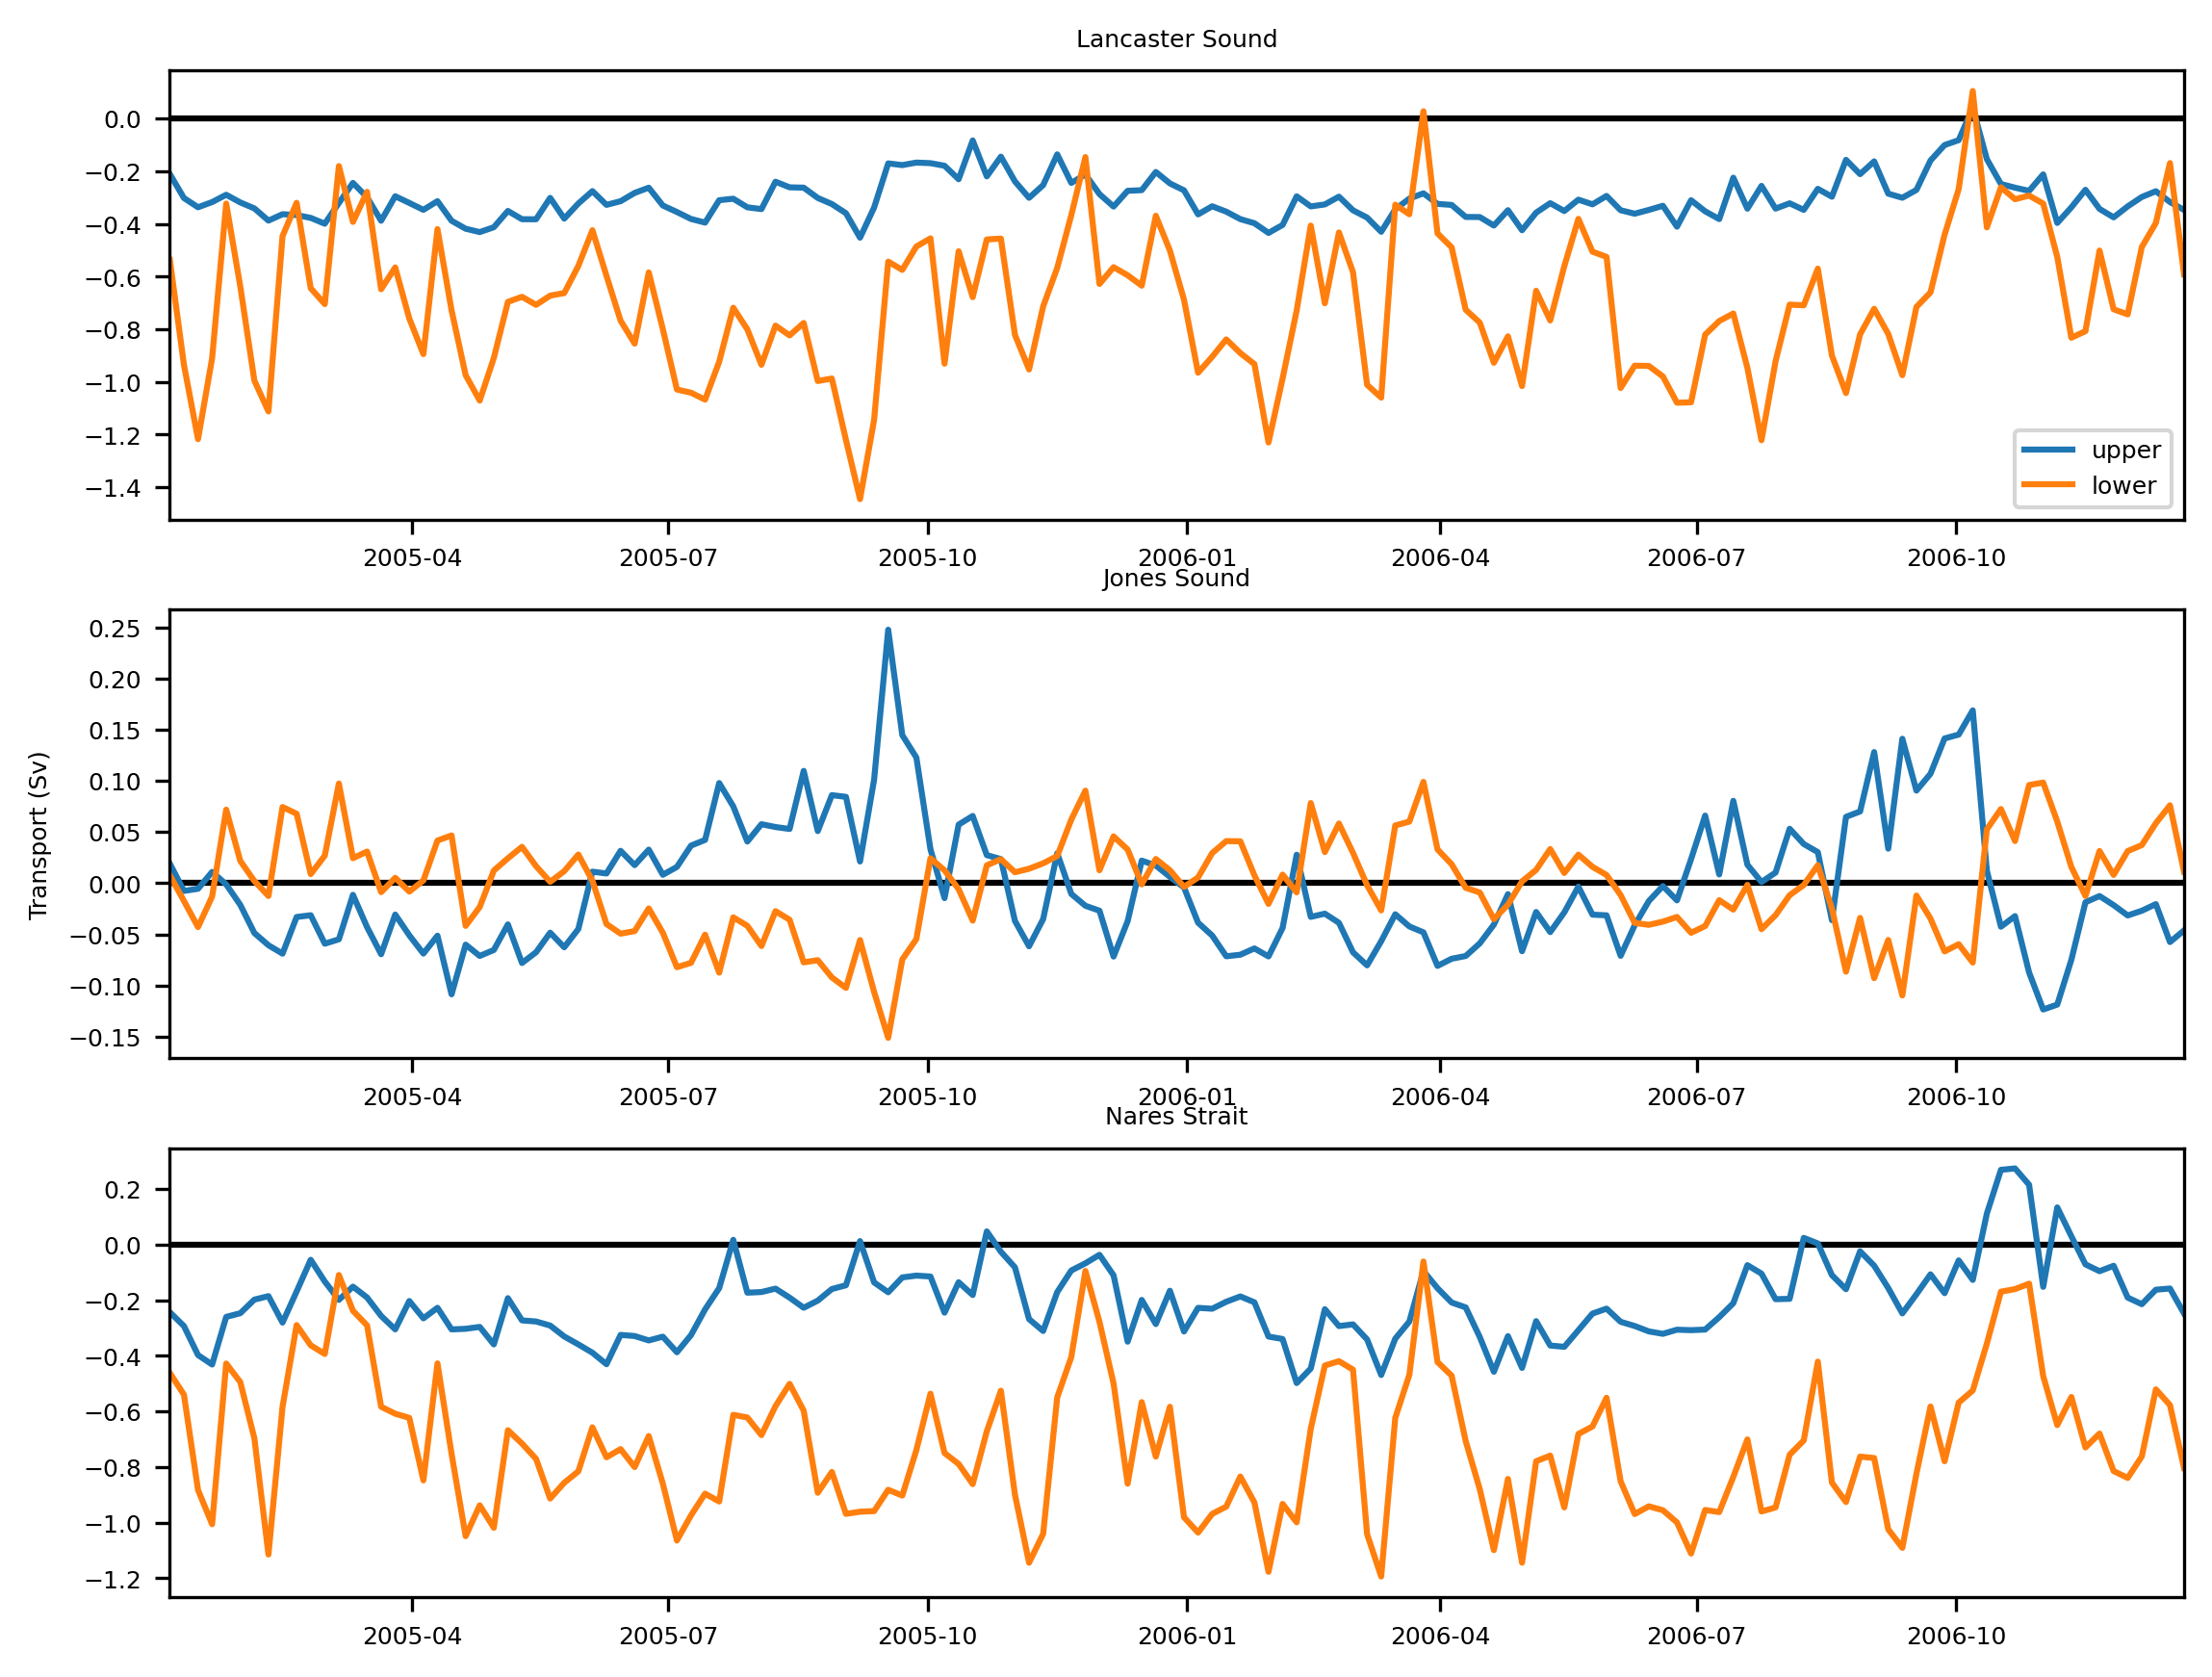

In [44]:
time_series, uJS, lJS, uNS, lNS, uLS, lLS = create_time_series(2005, 2006, total_export=False)

plot_transport(time_series, uJS, lJS, uNS, lNS, uLS, lLS)

#### Look at water masses at these boundaries

In [ ]:
def load_climatology(date):        
    # load year 2015 climatology of ANHA12 gridT file:
    df_gridT = xr.open_dataset(f'/data/brogalla/ANHA12/gridT_{date[0:4]}_climatology_{date[4:6]}.nc')
    
    bdy_temp = df_gridT['votemper'].values[0,:,:,:]
    bdy_sal  = df_gridT['vosaline'].values[0,:,:,:]
    
    return bdy_temp, bdy_sal

In [ ]:
dates = ['200509', '200510', '200511', '200512', '200601', '200602', '200603', '200604', '200605', '200606', '200607', '200608']

# For each boundary create an array of temperature and salinity with shape (month, depth level, position along boundary)
NS_T = np.empty((len(dates), 50, NS_len)); NS_S = np.empty((len(dates), 50, NS_len));
LS_T = np.empty((len(dates), 50, LS_len)); LS_S = np.empty((len(dates), 50, LS_len));
JS_T = np.empty((len(dates), 50, JS_len)); JS_S = np.empty((len(dates), 50, JS_len));

for d,date in enumerate(dates):
    
    T, S = load_climatology(date)
    
    NS_T[d,:,:] = T[:,NS[0]:NS[1],NS[2]]
    NS_S[d,:,:] = S[:,NS[0]:NS[1],NS[2]]
    LS_T[d,:,:] = T[:,LS[0],LS[2]:LS[3]]
    LS_S[d,:,:] = S[:,LS[0],LS[2]:LS[3]]
    JS_T[d,:,:] = T[:,JS[0],JS[2]:JS[3]]
    JS_S[d,:,:] = S[:,JS[0],JS[2]:JS[3]]

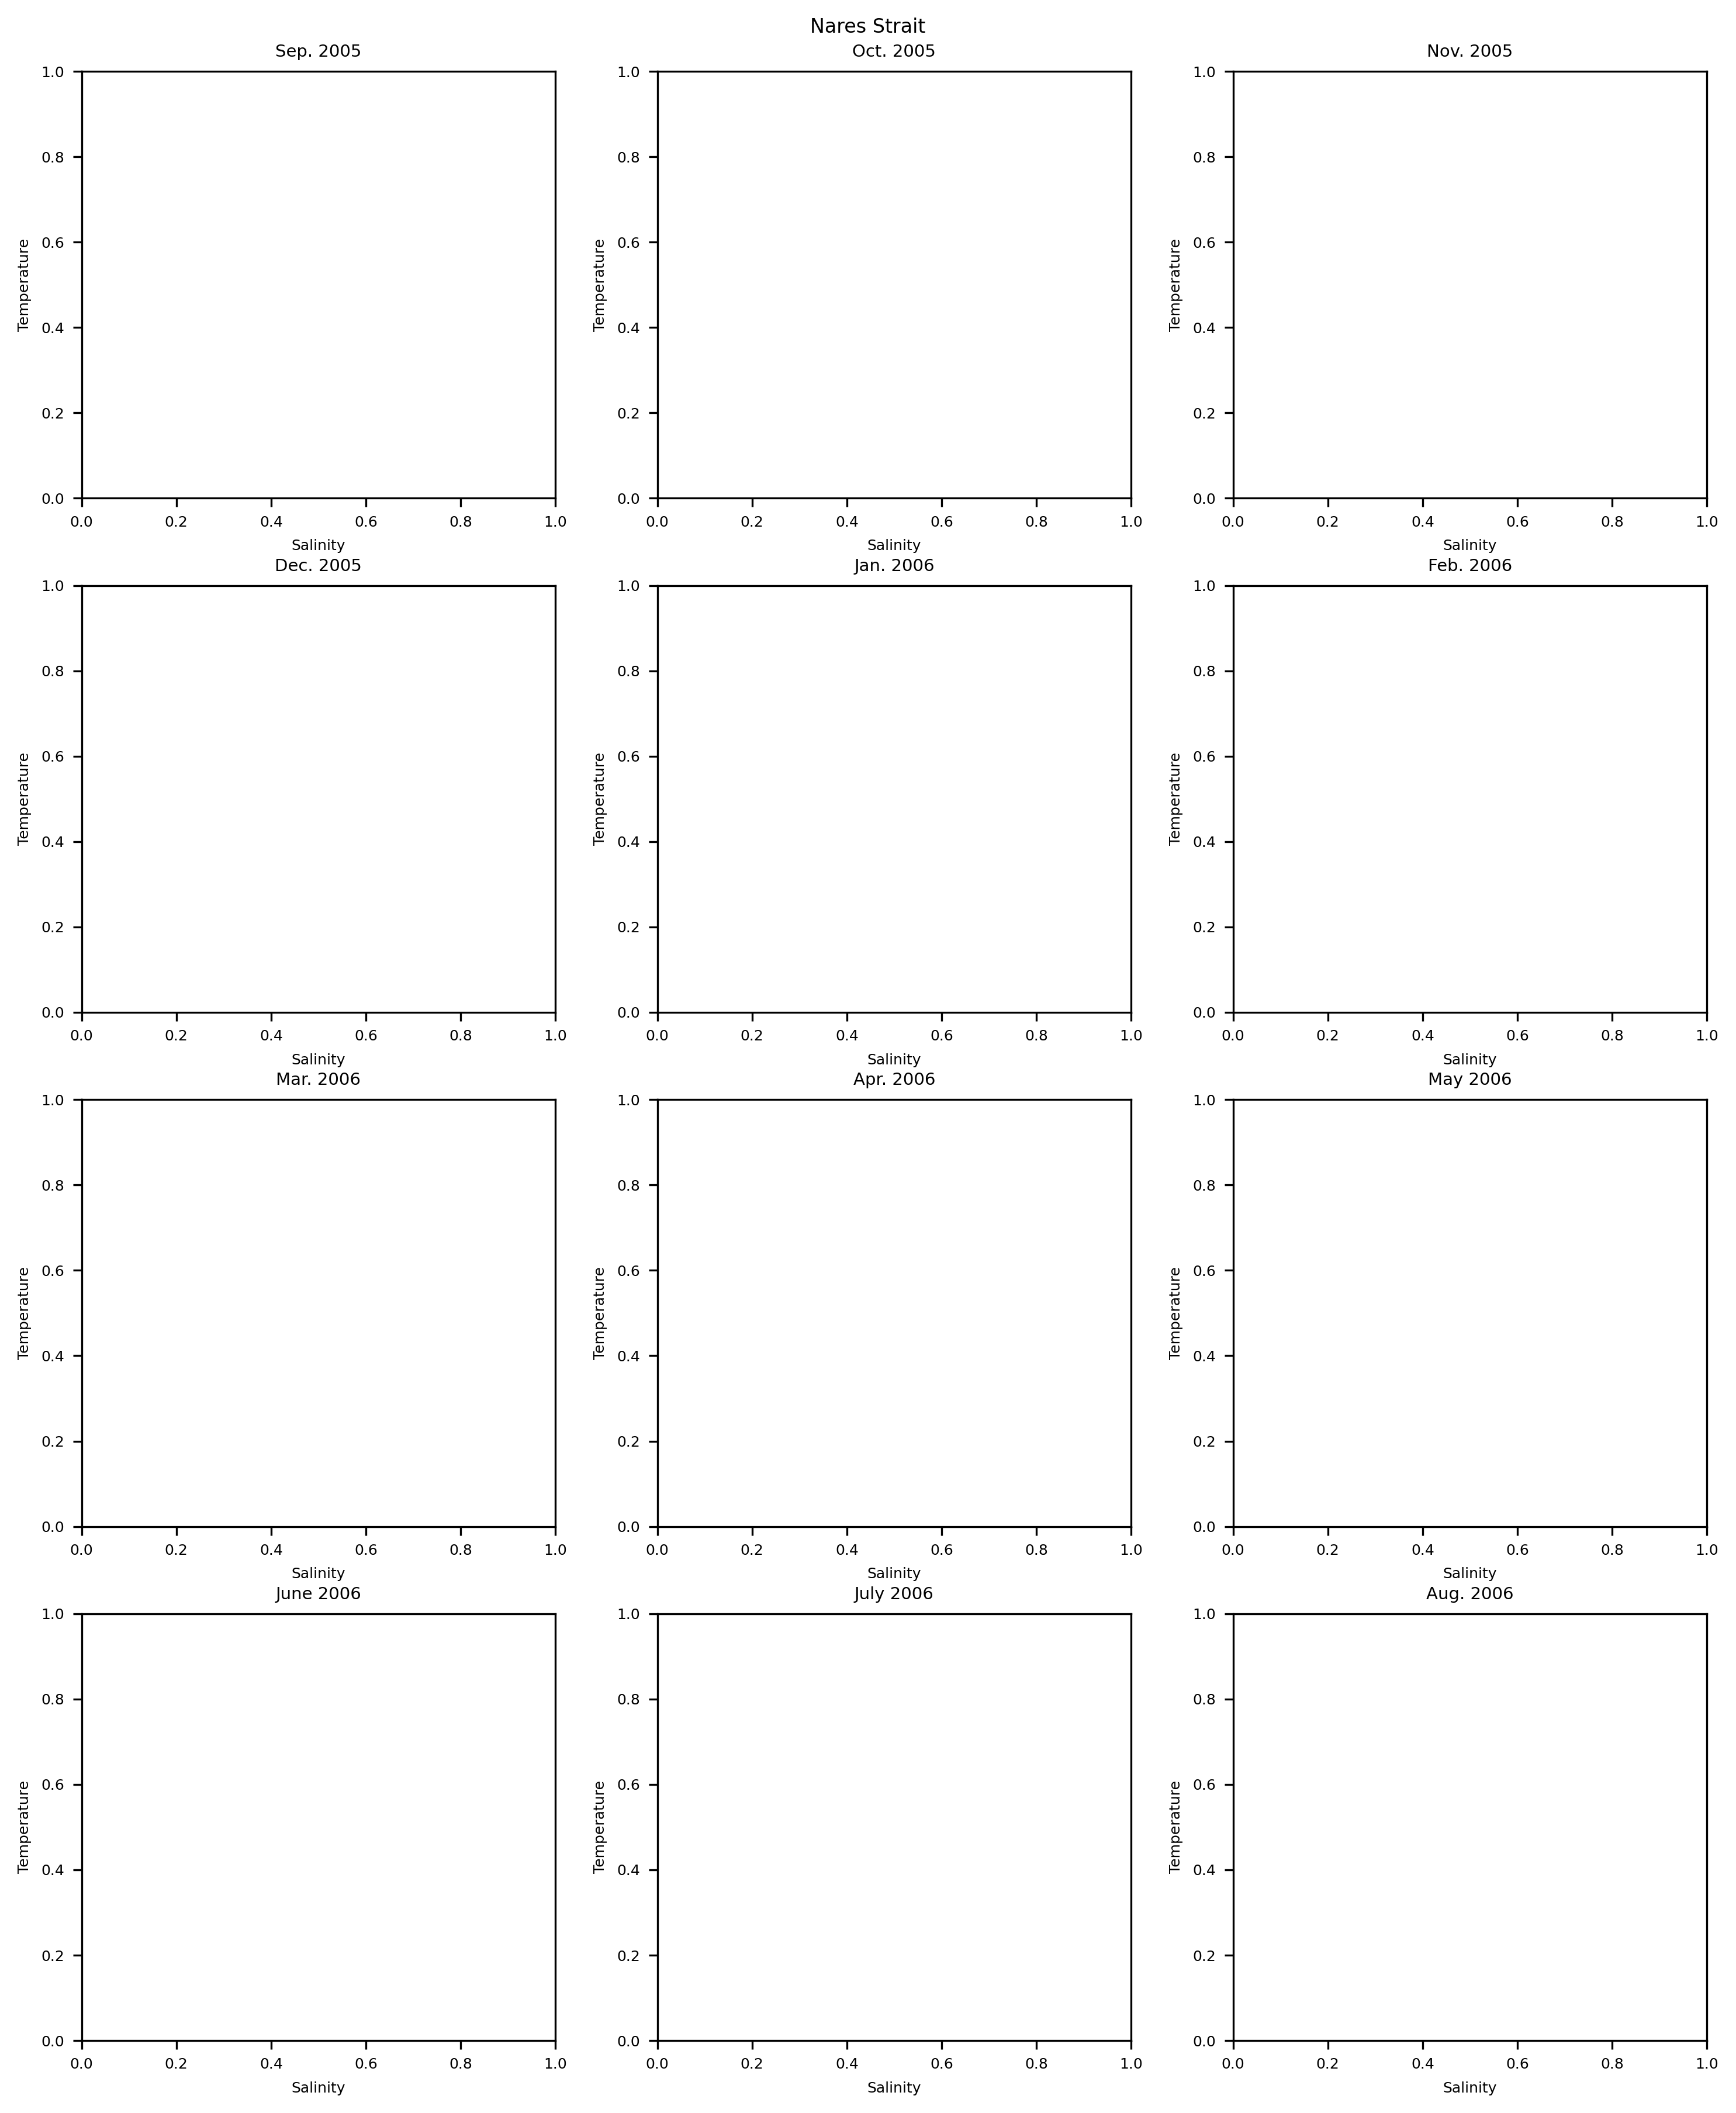

In [29]:
fig, ax = plt.subplots(4,3, figsize=(10,12), dpi=300)

fig.suptitle('Nares Strait', fontsize=8, y=1.00)

labels = ['Sep. 2005', 'Oct. 2005', 'Nov. 2005', 'Dec. 2005',\
          'Jan. 2006', 'Feb. 2006', 'Mar. 2006', 'Apr. 2006', \
          'May 2006', 'June 2006', 'July 2006', 'Aug. 2006']

for n,axis in enumerate(ax.ravel()):
    axis.set_title(labels[n], fontsize=7)
    axis.set_xlabel('Salinity', fontsize=6)
    axis.set_ylabel('Temperature', fontsize=6)
    axis.tick_params(labelsize=6)
    
#     axis.scatter(NS_S[n,:,:] , NS_T[n,:,:] , c='k', s=0.1, zorder=1, alpha=0.6)
    
plt.tight_layout(h_pad = 0.2)
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/NaresStrait_2005-2006_monthly_TS.jpg', dpi=300, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(4,3, figsize=(10,12), dpi=300)

fig.suptitle('Lancaster Sound', fontsize=8, y=1.00)

for n,axis in enumerate(ax.ravel()):
    axis.set_title(labels[n], fontsize=7)
    axis.set_xlabel('Salinity', fontsize=6)
    axis.set_ylabel('Temperature', fontsize=6)
    axis.tick_params(labelsize=6)
    
#     axis.scatter(LS_S[n,:,:] , LS_T[n,:,:] , c='k', s=0.1, zorder=1, alpha=0.6)
    
plt.tight_layout(h_pad = 0.2)
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/LancasterSound_2005-2006_monthly_TS.jpg', dpi=300, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(4,3, figsize=(10,12), dpi=300)

fig.suptitle('Jones Sound', fontsize=8, y=1.00)

for n,axis in enumerate(ax.ravel()):
    axis.set_title(labels[n], fontsize=7)
    axis.set_xlabel('Salinity', fontsize=6)
    axis.set_ylabel('Temperature', fontsize=6)
    axis.tick_params(labelsize=6)
    
#     axis.scatter(JS_S[n,:,:] , JS_T[n,:,:] , c='k', s=0.1, zorder=1, alpha=0.6)
    
plt.tight_layout(h_pad = 0.2)
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/JonesSound_2005-2006_monthly_TS.jpg', dpi=300, bbox_inches='tight')